In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from scipy.stats import ttest_1samp
import random
import copy

warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

# Get Data

In [2]:
price_data= yf.download('ZG', start='2009-10-1', end='2024-1-1')[['Adj Close','Volume']].reset_index()
price_data

[*********************100%%**********************]  1 of 1 completed


,Date,Adj Close,Volume
0,2011-07-20,11.153726,18751970
1,2011-07-21,10.352354,3136125
2,2011-07-22,10.685999,1208398
3,2011-07-25,11.100717,854024
4,2011-07-26,11.359526,952479
...,...,...,...
3128,2023-12-22,58.070000,722100
3129,2023-12-26,57.759998,442800
3130,2023-12-27,58.509998,320100
3131,2023-12-28,57.820000,578700


# Building Strategy

In [3]:
def macd_rsi_strategy(price_data):
    
    df = price_data.copy()
    # Calculate MACD
    df['EMA12'] = df['Adj Close'].ewm(span=12, adjust=False).mean()
    df['EMA26'] = df['Adj Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
    # Calculate RSI
    delta = df['Adj Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=7).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=7).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    
    # Generate signals
    df['Buy_Signal'] = ((df['MACD'] > df['Signal_Line']) & (df['RSI'] > 70)).astype(int)
    df['Sell_Signal'] = ((df['MACD'] < df['Signal_Line']) & (df['RSI'] < 20)).astype(int)
    
    return df

In [24]:
def calculate_positions(price_data):
    start_date= '2018-01-01'
    end_date= '2024-01-01'
    data = copy.deepcopy(price_data)
    data = data[(data.Date>start_date)&(data.Date<end_date)]
    data['Returns'] = data['Adj Close'].pct_change(1).fillna(0)
    data = data.dropna()
    # If a Buy_Signal is given, we will hold the position for 20 trading days
    data['Position'] = pd.NA
    for i in range(1,len(data)):
        if data['Buy_Signal'].iloc[i] == 1:
            data['Position'].iloc[i] = 1
    stop_period = 5
    for i in range(len(data)):
        if data['Sell_Signal'].iloc[i] == 1:
            data['Position'].iloc[i:i+stop_period] = 0

    data['Position'].fillna(method='ffill', inplace=True)
    data['Position'] = data['Position'].fillna(0)
    # Calculate daily returns\
    data['Position'] = data['Position'].shift(1)
    data['Position'].iloc[0]=0
    data['Position'].iloc[-1] = 0
    data['Total_returns'] = (1 + data.Returns*data.Position).cumprod()-1
    data['BH_returns'] = (1 + data.Returns).cumprod()-1
    
    data['Round'] = data['Position'].diff().fillna(0)
    return data

In [25]:
def Backtesting_performance(data):
    
    df = copy.deepcopy(data)
    
    # 1. Identify round-trip trades (a buy followed by a sell)
    round_trip_trades = df[df.Round == 1].shape[0]
    
    # 2. Calculate the total return for the stocks
    total_return_pct = df['Total_returns'].iloc[-1]*100
    total_return_pct = np.round(total_return_pct,2)    
    # 3. Total Sharpe Ratio:                  
    risk_free_rate = 0.02
    excess_returns = [r - risk_free_rate for r in df['Total_returns'].fillna(0)]
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns)
    sharpe_ratio = np.round(sharpe_ratio,2) 
    # 4. Calculate Buy & Hold return
    buy_and_hold_return_pct = ((df['Adj Close'].iloc[-1]/df['Adj Close'].iloc[0])-1)*100
    buy_and_hold_return_pct  = np.round(buy_and_hold_return_pct,2)           
    # 5. B&H Sharpe Ratio:
    risk_free_rate = 0.02
    excess_returns_bh = [r - risk_free_rate for r in df['BH_returns'].fillna(0)]
    sharpe_ratio_bh = np.mean(excess_returns_bh) / np.std(excess_returns_bh)
    sharpe_ratio_bh = np.round(sharpe_ratio_bh,2)              
    
    # 6. Calculate winning trades percentage
    entry_prices = df[df.Round == 1]['Adj Close']
    exit_prices = df[df.Round == -1]['Adj Close']
    trade_returns = exit_prices.values - entry_prices.values
    winning_trades = (trade_returns >= 0).sum()
    total_trades = df[(df.Round == 1)|(df.Round == -1)].shape[0] / 2
    winning_rate = (winning_trades / total_trades) * 100
    winning_rate  = np.round(winning_rate,2)
    
    # 7. Calculate max drawdown
    running_max = (df['Total_returns']+1).cummax()
    drawdowns = (df['Total_returns'] - running_max) / running_max
    max_drawdown_pct = drawdowns.min()*100
    max_drawdown_pct = np.round(max_drawdown_pct,2)
    
    return {
        'Round-trip trades': round_trip_trades,
        'Total Return, %': total_return_pct,
        'Sharpe Ratio, %': sharpe_ratio,
        'B & H return, %': buy_and_hold_return_pct,
        'B & H Sharpe Ratio': sharpe_ratio_bh,
        'Winning trades, %': winning_rate,
        'Max drawdown, %': max_drawdown_pct
    }

In [26]:
test_data = calculate_positions(macd_rsi_strategy(price_data))
test_data

,Date,Adj Close,Volume,EMA12,EMA26,MACD,Signal_Line,Volume20,RSI,Buy_Signal,Sell_Signal,Returns,Position,Total_returns,BH_returns,Round
1624,2018-01-02,42.299999,277300,41.613468,41.401884,0.211584,0.226066,2.670332e+05,42.622930,0,0,0.000000,0.0,0.000000,0.000000,0.0
1625,2018-01-03,42.730000,372700,41.785242,41.500263,0.284979,0.237849,2.770967e+05,58.529388,0,0,0.010165,0.0,0.000000,0.010165,0.0
1626,2018-01-04,42.009998,255100,41.819820,41.538021,0.281799,0.246639,2.750018e+05,48.894346,0,0,-0.016850,0.0,0.000000,-0.006856,0.0
1627,2018-01-05,42.340000,127300,41.899848,41.597427,0.302421,0.257795,2.609349e+05,56.447673,0,0,0.007855,0.0,0.000000,0.000946,0.0
1628,2018-01-08,42.619999,218600,42.010640,41.673173,0.337467,0.273729,2.569030e+05,64.356444,0,0,0.006613,0.0,0.000000,0.007565,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3128,2023-12-22,58.070000,722100,52.603600,47.813446,4.790154,3.599222,1.063329e+06,86.435917,0,0,0.001725,1.0,4.358373,0.372813,0.0
3129,2023-12-26,57.759998,442800,53.396892,48.550228,4.846664,3.848711,1.004231e+06,74.041276,0,0,-0.005338,1.0,4.329768,0.365485,0.0
3130,2023-12-27,58.509998,320100,54.183524,49.287989,4.895535,4.058075,9.390760e+05,75.724121,0,0,0.012985,1.0,4.398974,0.383215,0.0
3131,2023-12-28,57.820000,578700,54.742982,49.919990,4.822992,4.211059,9.047545e+05,66.847078,0,0,-0.011793,1.0,4.335304,0.366903,0.0


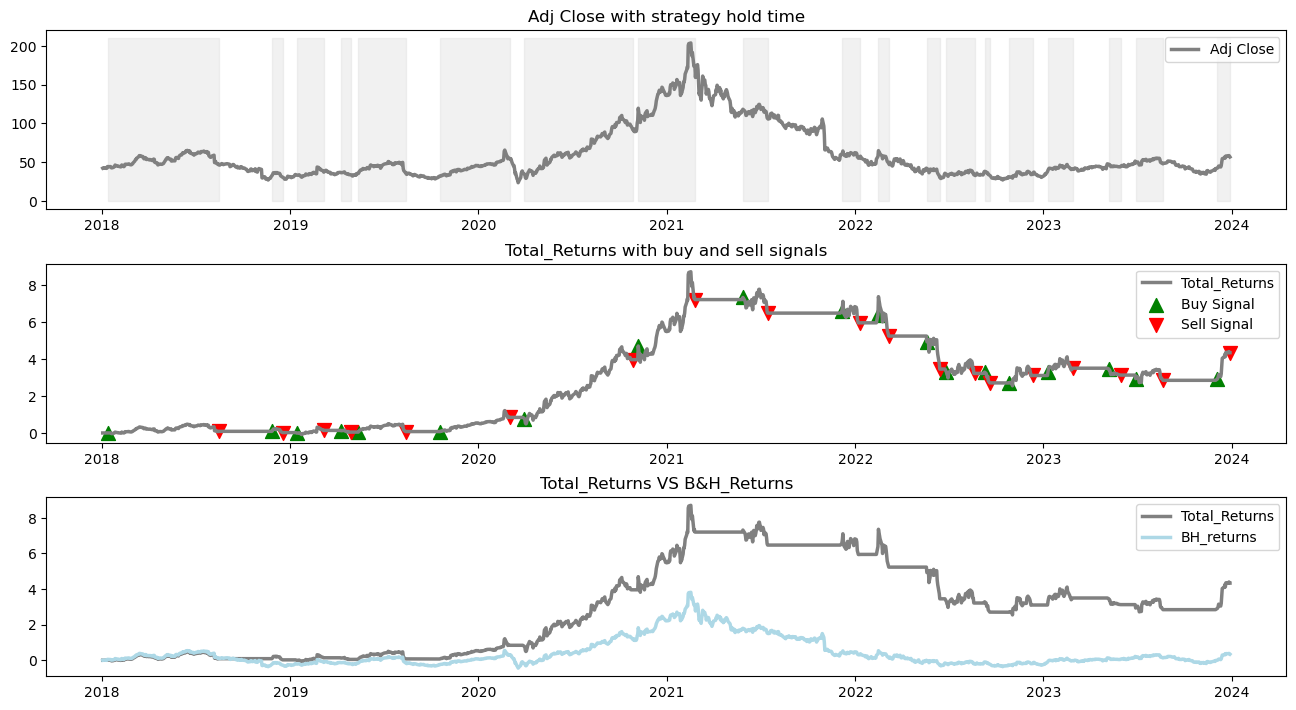

In [27]:
plt.figure(figsize=(16, 9))
ax1 = plt.subplot2grid((15,1), (0,0), rowspan = 4, colspan = 1)
ax2 = plt.subplot2grid((15,1), (5,0), rowspan = 4, colspan = 1)
ax3 = plt.subplot2grid((15,1), (10,0), rowspan = 4, colspan = 1)
ax1.plot(test_data['Date'], test_data['Adj Close'], linewidth = 2.5,color = 'grey',label = 'Adj Close')
# ax1.plot(test_data['Date'], test_data.Round == 1, marker = '^', markersize = 10, color = 'green', label = 'BUY SIGNAL')
# ax1.plot(test_data['Date'], test_data.Round == -1, marker = 'v', markersize = 10, color = 'r', label = 'SELL SIGNAL')
ax1.set_title('Adj Close with strategy hold time')
# plt.scatter(test_data['Date'][test_data.Round == 1], test_data['Adj Close'][test_data.Round == 1],color='green', marker='^', label='Round = 1',s=100)
# plt.scatter(test_data['Date'][test_data.Round == -1], test_data['Adj Close'][test_data.Round == -1], color='r',marker='v', label='Round = -1',s=100)
for i in range(len(test_data) - 1):
    if test_data['Round'].iloc[i] == 1:
        for j in range(i + 1, len(test_data)):
            if test_data['Round'].iloc[j] == -1:
                ax1.fill_between(test_data['Date'][i:j+1], 210, color='lightgrey', alpha=0.3)  # alpha 调整填充的透明度
                break  
ax1.legend()

# plt.plot(test_data['Date'], test_data['Total_returns'], linewidth = 2.5, color = 'skyblue', label = 'DIS')
ax2.plot(test_data['Date'], test_data['Total_returns'], linewidth = 2.5,color = 'grey',label = 'Total_Returns')
# ax1.plot(test_data['Date'], test_data.Round == 1, marker = '^', markersize = 10, color = 'green', label = 'BUY SIGNAL')
# ax1.plot(test_data['Date'], test_data.Round == -1, marker = 'v', markersize = 10, color = 'r', label = 'SELL SIGNAL')
ax2.set_title('Total_Returns with buy and sell signals')
ax2.scatter(test_data['Date'][test_data.Round == 1], test_data['Total_returns'][test_data.Round == 1],color='green', marker='^',s=100,label = 'Buy Signal')
ax2.scatter(test_data['Date'][test_data.Round == -1], test_data['Total_returns'][test_data.Round == -1], color='r',marker='v',s=100,label = 'Sell Signal')
ax2.legend()

ax3.plot(test_data['Date'], test_data['Total_returns'], linewidth = 2.5,color = 'grey',label = 'Total_Returns')
ax3.plot(test_data['Date'], test_data['BH_returns'], linewidth = 2.5,color = 'lightblue',label = 'BH_returns')
# ax1.plot(test_data['Date'], test_data.Round == 1, marker = '^', markersize = 10, color = 'green', label = 'BUY SIGNAL')
# ax1.plot(test_data['Date'], test_data.Round == -1, marker = 'v', markersize = 10, color = 'r', label = 'SELL SIGNAL')
ax3.set_title('Total_Returns VS B&H_Returns')
ax3.legend()

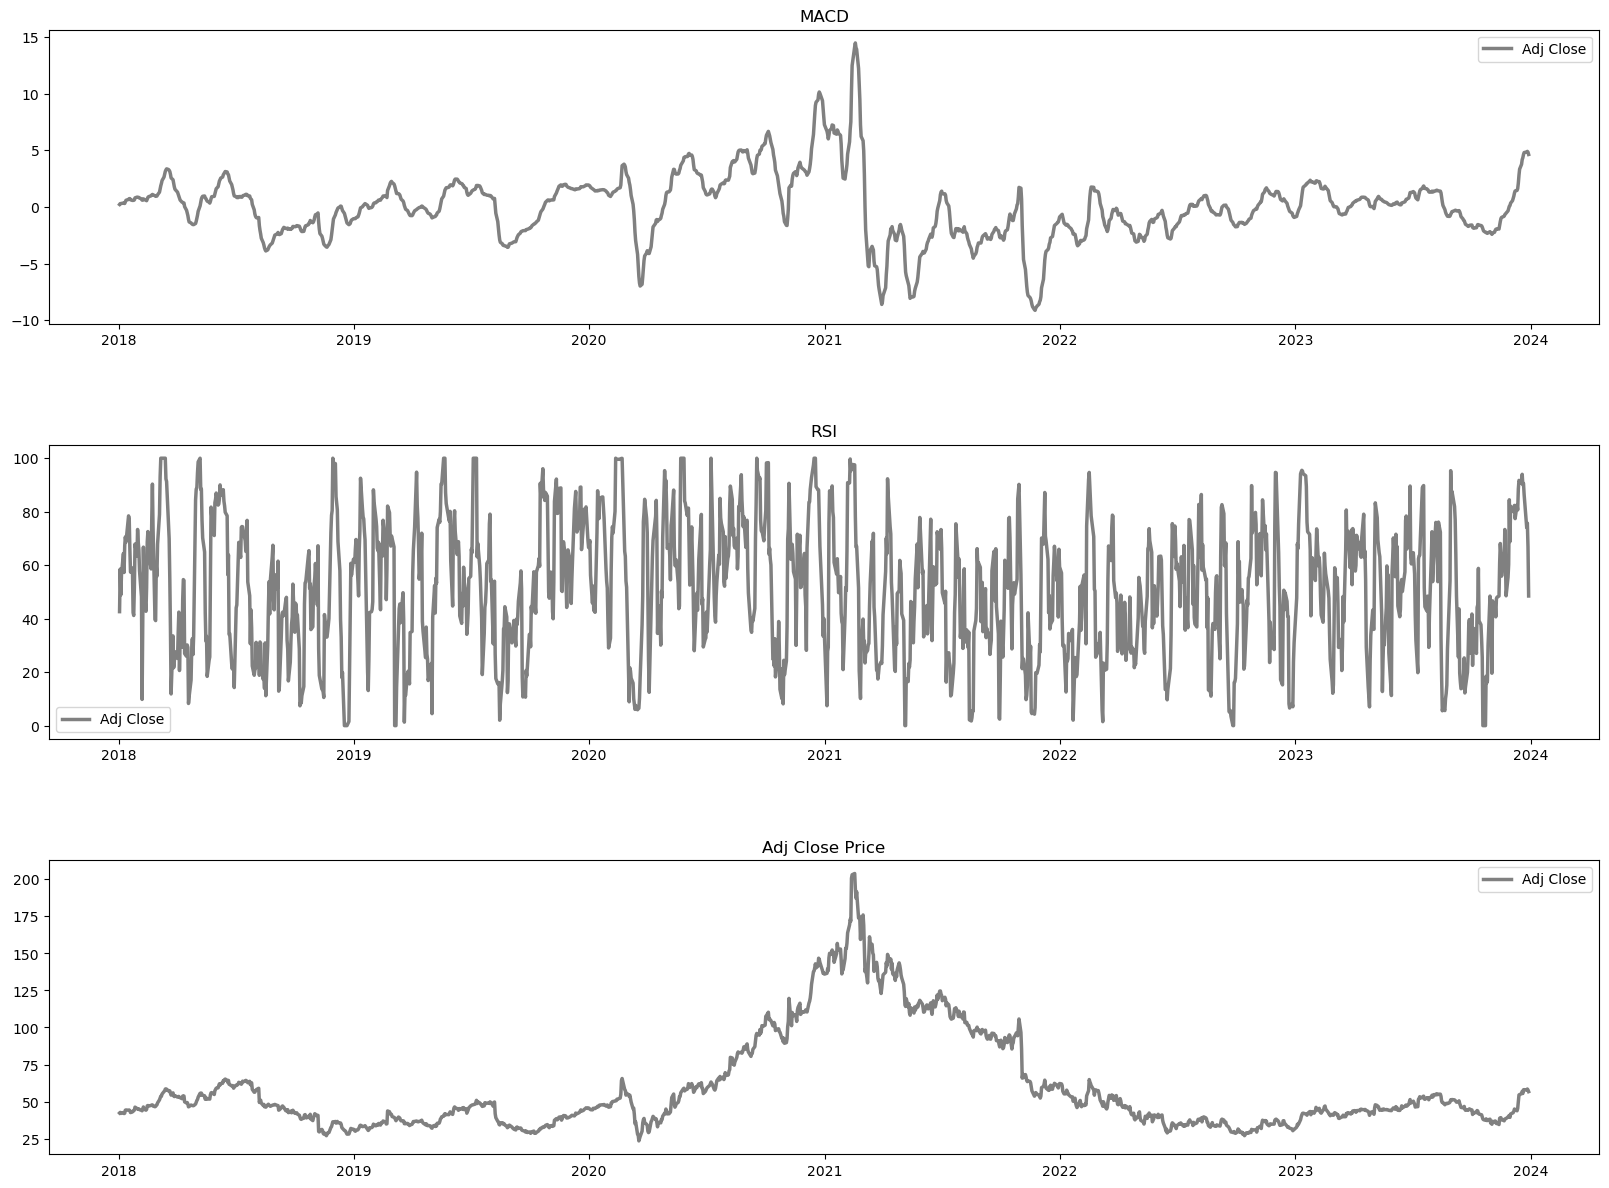

In [44]:
plt.figure(figsize=(20, 20))
ax1 = plt.subplot2grid((15,1), (0,0), rowspan=3, colspan=1)

# The second subplot spans rows 4 to 6 (three rows total).
ax2 = plt.subplot2grid((15,1), (4,0), rowspan=3, colspan=1)

# The third subplot spans rows 8 to 10 (three rows total).
ax3 = plt.subplot2grid((15,1), (8,0), rowspan=3, colspan=1)



ax1.plot(test_data['Date'], test_data['MACD'], linewidth = 2.5,color = 'grey',label = 'Adj Close')
ax1.set_title('MACD')
ax1.legend()

# ax2.plot(test_data['Date'], test_data['Adj Close'], linewidth = 2.5,color = 'grey',label = 'Adj Close')
ax2.plot(test_data['Date'], test_data['RSI'], linewidth = 2.5,color = 'grey',label = 'Adj Close')
ax2.set_title('RSI')
# plt.scatter(test_data['Date'][test_data.Round == 1], test_data['Adj Close'][test_data.Round == 1],color='green', marker='^', label='Round = 1',s=100)
# plt.scatter(test_data['Date'][test_data.Round == -1], test_data['Adj Close'][test_data.Round == -1], color='r',marker='v', label='Round = -1',s=100)
ax2.legend()

ax3.plot(test_data['Date'], test_data['Adj Close'], linewidth = 2.5,color = 'grey',label = 'Adj Close')
ax3.set_title('Adj Close Price')
ax3.legend()



## pnl

In [28]:
index_list = test_data.index[(test_data['Round'] == 1) | (test_data['Round'] == -1)].to_list()
pd.DataFrame([Backtesting_performance(test_data.loc[index_list[0]:index_list[1]])])
pnl_historical = pd.DataFrame()
for i in range(0,len(index_list)-1,2):
    data = pd.DataFrame([Backtesting_performance(test_data.loc[index_list[i]:index_list[i+1]])])
    pnl_historical = pd.concat([pnl_historical, data], ignore_index=True)
pnl_historical

,Round-trip trades,"Total Return, %","Sharpe Ratio, %","B & H return, %",B & H Sharpe Ratio,"Winning trades, %","Max drawdown, %"
0,1,8.79,1.34,4.87,1.63,100.0,-103.63
1,1,2.11,1.89,-8.21,-4.18,0.0,-98.27
2,1,13.85,0.48,11.98,-2.20,100.0,-108.39
3,1,4.61,1.98,-7.70,-6.04,0.0,-96.41
4,1,7.59,2.58,-2.26,0.42,0.0,-95.46
5,1,84.05,1.87,68.54,0.11,100.0,-93.47
6,1,395.91,2.22,166.58,1.15,100.0,-72.38
7,1,720.35,4.63,33.24,3.80,100.0,-32.93
8,1,647.29,21.32,-10.72,15.13,0.0,-26.11
9,1,594.86,21.32,-4.21,7.22,0.0,-26.73


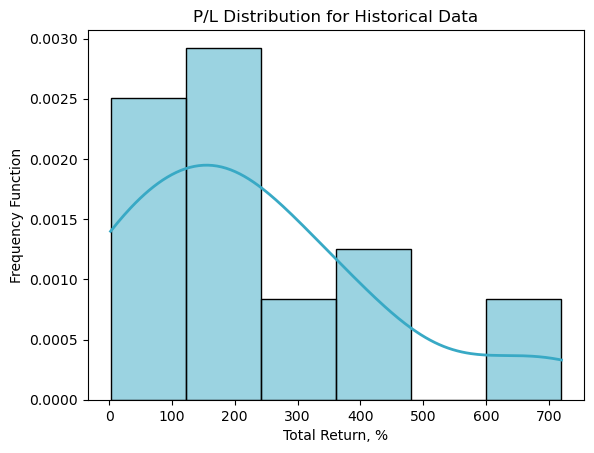

In [16]:
import seaborn as sns
sns.histplot(data=pnl_historical, x='Total Return, %', kde=True, stat='density', color=palette[3], line_kws={'linewidth': 2})

# Set the title and labels
plt.title('P/L Distribution for Historical Data')
plt.xlabel('Total Return, %')
plt.ylabel('Frequency Function')  # Change this to 'Density' if you prefer

# Display the plot
plt.show()

In [836]:
# Get the list of returns
returns = pnl_historical['Total Return, %']

# Calculate the mean return
mean_return = sum(returns) / len(returns)

# Perform a one-sample t-test against zero
t_statistic, p_value = ttest_1samp(returns, 0)

# Print the t-statistic and p-value
print("t-statistic:", round(t_statistic,2))
print("p-value:", p_value)

# Check if the mean return differs significantly from zero at the 99% confidence level
if p_value < 0.01:
    print("The mean return differs significantly from zero at the 99% confidence level.")
else:
    print("The mean return does not differ significantly from zero at the 99% confidence level.")


t-statistic: 5.65
p-value: 2.3434597372131558e-05
The mean return differs significantly from zero at the 99% confidence level.


In [40]:
index_list = test_data.index[(test_data['Round'] == 1) | (test_data['Round'] == -1)].to_list()
pd.DataFrame([Backtesting_performance(test_data.loc[index_list[0]:index_list[1]])])
historical_Trading_Round = pd.DataFrame()
for i in range(0,len(index_list)-1,2):
    data = pd.DataFrame([Backtesting_performance(test_data.loc[index_list[i]:index_list[i+1]])])
    data['Buy_Date'] = test_data.loc[index_list[i]]['Date']
    data['Round'] = i//2 +1
    data['Sell_Date'] = test_data.loc[index_list[i+1]]['Date']
    data['Buy_Price'] = test_data.loc[index_list[i]]['Adj Close']
    data['Sell_Price'] = test_data.loc[index_list[i+1]]['Adj Close']
    historical_Trading_Round = pd.concat([historical_Trading_Round, data], ignore_index=True)
historical_Trading_Round = historical_Trading_Round[['Round','Buy_Date','Buy_Price','Sell_Date','Sell_Price','Total Return, %','Sharpe Ratio, %']]

In [43]:
historical_Trading_Round.to_csv('test.csv')

# bootstrap

In [29]:
def bootstrap_Price_Sample(price_df_null):
    stock_close_df = price_df_null.copy()

    # 1. Store the first day close price
    new_price_list = []
    new_price_list.append(stock_close_df.iloc[0,1])
    new_price_list.append(stock_close_df.iloc[1,1])

    new_return_list = []
    new_return_list.append(None)
    new_return_list.append(np.log(new_price_list[1] / new_price_list[0]))

    # 2. Create a new dataframe to store the new price sample
    new_price_sample_i = pd.DataFrame(stock_close_df.iloc[:,0])

    # 3. Calculate Log Returns
    stock_close_df['log_returns'] = np.log(stock_close_df['Adj Close'] / stock_close_df['Adj Close'].shift(1))
    stock_close_df = stock_close_df.dropna()

    # 4. AR(1) model for logarithmic returns rt (estimate with OLS)

    # 4.1 Create a lagged return variable
    stock_close_df['lag_log_return'] = stock_close_df['log_returns'].shift(1)

    # 4.2 Drop the first row of the DataFrame
    stock_close_df = stock_close_df.dropna()

    # 4.3 Define the dependent and independent variables
    y = stock_close_df['log_returns']
    X = stock_close_df[['lag_log_return']]

    # 4.4 Add a constant term to the independent variable
    X = sm.add_constant(X)

    # 4.5 Fit the OLS model
    temp_model = sm.OLS(y, X).fit()
    temp_model_a = temp_model.params[0]
    temp_model_b = temp_model.params[1]

    # 4.6 Calculate the model residuals
    model_residuals_list = temp_model.resid.tolist()

    # 5. Bootstrap
    # 5.1 Bootstrap residuals
    for i in range(len(stock_close_df)):
        temp_bootstrap_e = random.choices(model_residuals_list, k=1)
        new_return_list.append(temp_model_a + temp_model_b*new_return_list[-1] + temp_bootstrap_e[0])
        new_price_list.append(new_price_list[-1]*np.exp(new_return_list[-1]))

    # new_price_sample_i['Log_Return'] = new_return_list
    new_price_sample_i['Adj Close'] = new_price_list
    new_price_sample_i = pd.merge(new_price_sample_i,price_df_null[['Date','Volume']],on = 'Date',how='outer')
    return new_price_sample_i

In [30]:
all_resample_data = pd.DataFrame(columns=['Sample','Round-trip trades',
                                          'Total Return, %','Sharpe Ratio, %',
                                          'B & H return, %','B & H Sharpe Ratio',
                                          'Winning trades, %','Max drawdown, %'])
for i in range(200):
    dd = Backtesting_performance(calculate_positions(macd_rsi_strategy(bootstrap_Price_Sample(price_data))))
    dd = pd.DataFrame([dd])
    dd['Sample'] = 'B'+str(i+1)
    all_resample_data = pd.concat([all_resample_data, dd], ignore_index=True) 

In [31]:
all_resample_data.mean()

Round-trip trades      26.04500
Total Return, %       160.42445
Sharpe Ratio, %         0.28150
B & H return, %       365.75110
B & H Sharpe Ratio      0.18900
Winning trades, %      41.28325
Max drawdown, %      -128.51080
dtype: float64

In [33]:
pd.DataFrame([Backtesting_performance(test_data)])

,Round-trip trades,"Total Return, %","Sharpe Ratio, %","B & H return, %",B & H Sharpe Ratio,"Winning trades, %","Max drawdown, %"
0,19,433.53,1.15,34.09,0.49,42.11,-105.76


In [37]:
all_resample_data.to_csv('all_sample.csv')

## bootstrap pnl plot

In [34]:
dd = pd.DataFrame([all_resample_data.mean()])
all_Test = pd.concat([all_resample_data, dd], ignore_index=True)

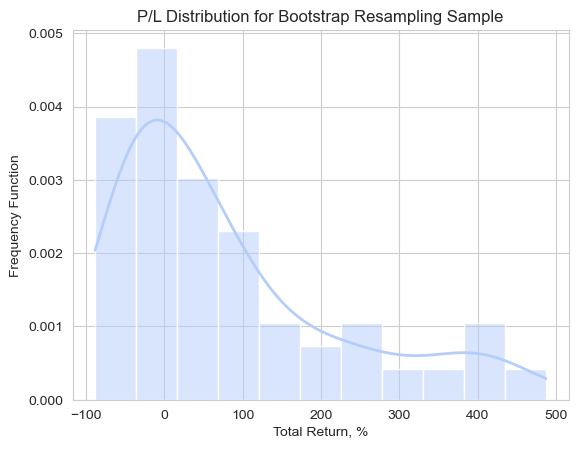

In [793]:
sns.histplot(data=all_resample_data1, x='Total Return, %', kde=True, stat='density', color=palette[3], line_kws={'linewidth': 2})

# Set the title and labels
plt.title('P/L Distribution for Bootstrap Resampling Sample')
plt.xlabel('Total Return, %')
plt.ylabel('Frequency Function')  # Change this to 'Density' if you prefer

# Display the plot
plt.show()

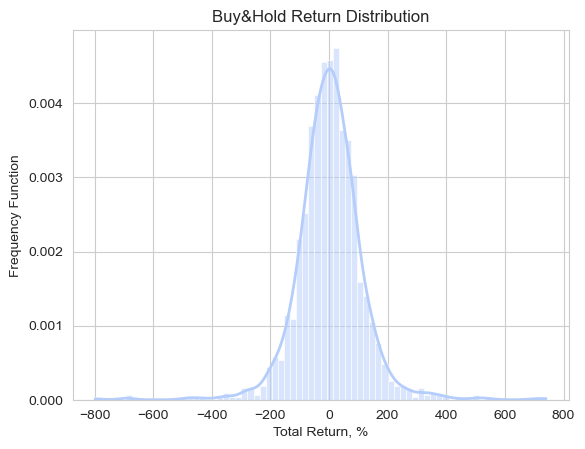

In [797]:
test = test_data.copy()
test['Returns'] = test['Returns']*3000
sns.histplot(data=test, x='Returns', kde=True, stat='density', color=palette[3], line_kws={'linewidth': 2})
# Set the title and labels
plt.title('Buy&Hold Return Distribution')
plt.xlabel('Total Return, %')
plt.ylabel('Frequency Function')  # Change this to 'Density' if you prefer

# Display the plot
plt.show()

In [835]:
# Get the list of returns
returns = all_resample_data1['Total Return, %']

# Calculate the mean return
mean_return = sum(returns) / len(returns)

# Perform a one-sample t-test against zero
t_statistic, p_value = ttest_1samp(returns, 0)

# Print the t-statistic and p-value
print("t-statistic:", round(t_statistic,2))
print("p-value:", p_value)

# Check if the mean return differs significantly from zero at the 99% confidence level
if p_value < 0.01:
    print("The mean return differs significantly from zero at the 99% confidence level.")
else:
    print("The mean return does not differ significantly from zero at the 99% confidence level.")


t-statistic: 7.35
p-value: 6.609897886356083e-12
The mean return differs significantly from zero at the 99% confidence level.
